# SMA Strategy and Backtesting

Extracted from lecture 2 of Algorithmic Trading, original source obtained from  [Algorithmic Trading Society Lectures Imperial College London](https://github.com/algotradingsoc/Lectures2022/blob/main/AlgoTradeSocLectures.ipynb).

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
GBPUSD = yf.download("GBPUSD=X", start = "2006-01-01", end = "2022-09-06")
df = pd.DataFrame()
df["price"] = GBPUSD["Close"]

[*********************100%***********************]  1 of 1 completed


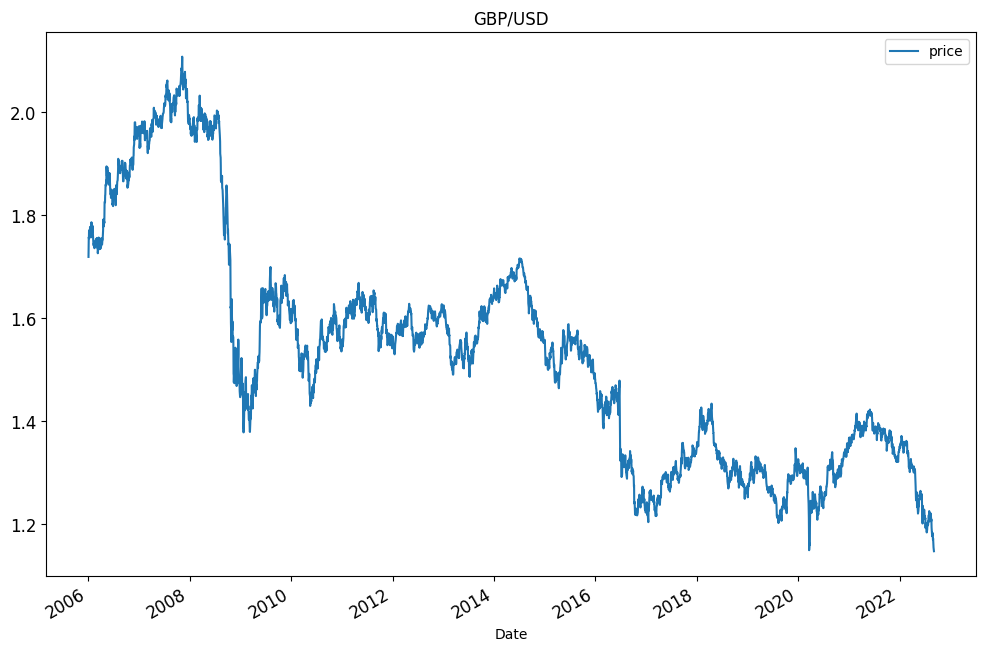

In [11]:
df.plot(figsize = (12, 8), title = "GBP/USD", fontsize = 12)
plt.show()

In [12]:
df["returns"] = np.emath.log(df.div(df.shift(1)))
df = df.fillna(0)


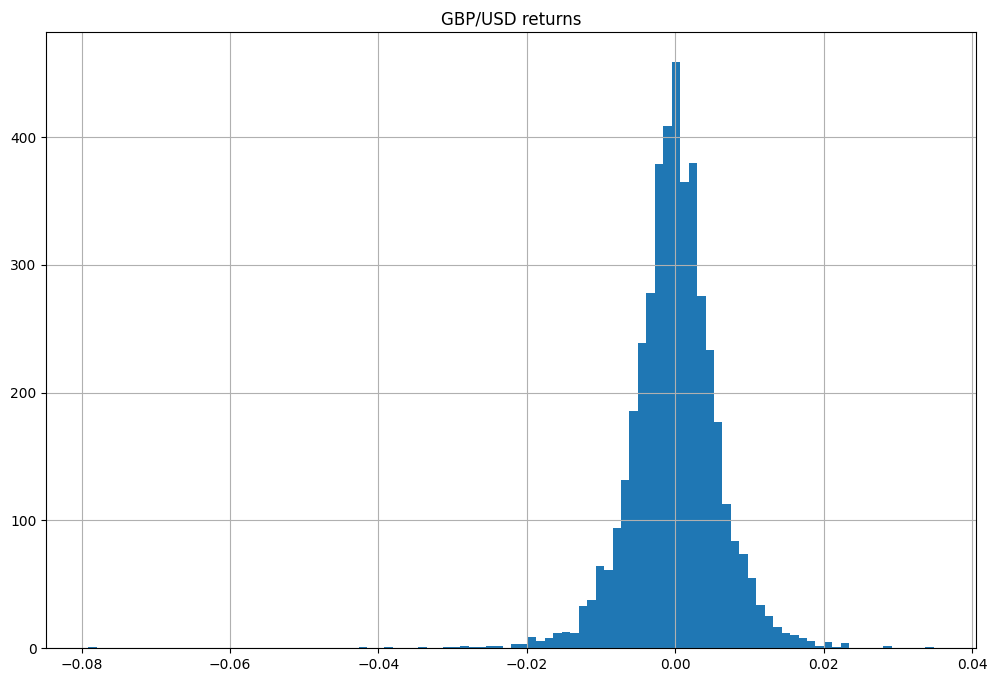

In [14]:
df.returns.hist(bins = 100, figsize = (12, 8))
plt.title("GBP/USD returns")
plt.show()

In [17]:
df.returns.sum()
np.exp(df.returns.sum())
df.price[-1] / df.price[0]
df.returns.cumsum().apply(np.exp)
df["creturns"] = df.returns.cumsum().apply(np.exp)

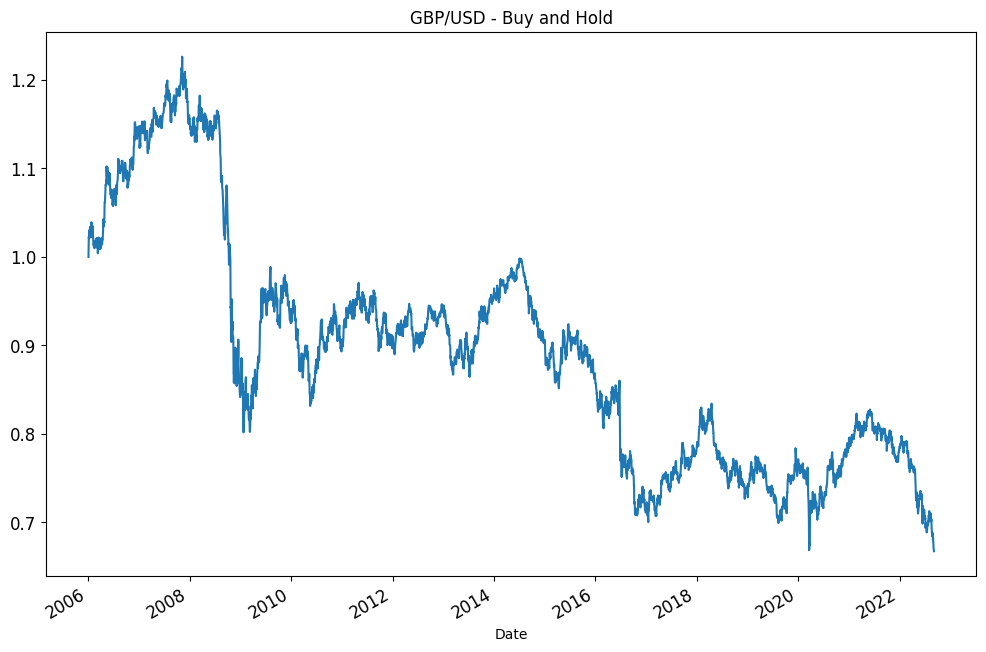

In [19]:
df.creturns.plot(figsize = (12, 8), title = "GBP/USD - Buy and Hold", fontsize = 12)
plt.show()

### Performance metrics

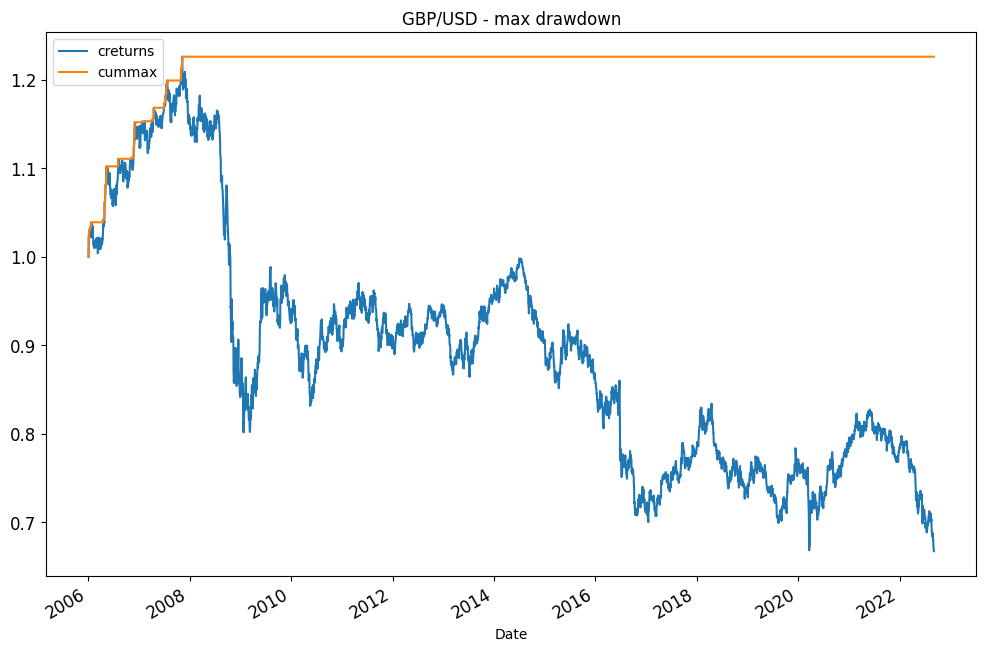

In [22]:
df.creturns.iloc[-1] # absolute Performance 
df.returns.sum() # absolute Performance
df.returns.mean() * 252 # mean return
df.returns.std() * np.sqrt(252) # risk
df["cummax"] = df.creturns.cummax()
df[["creturns", "cummax"]].dropna().plot(figsize = (12, 8), title = "GBP/USD - max drawdown", fontsize = 12)
plt.show()

In [24]:
drawdown = df["cummax"] - df["creturns"]
drawdown.max() # maximum drawdown

0.558829180659861

### Defining an SMA strategy

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

[*********************100%***********************]  1 of 1 completed


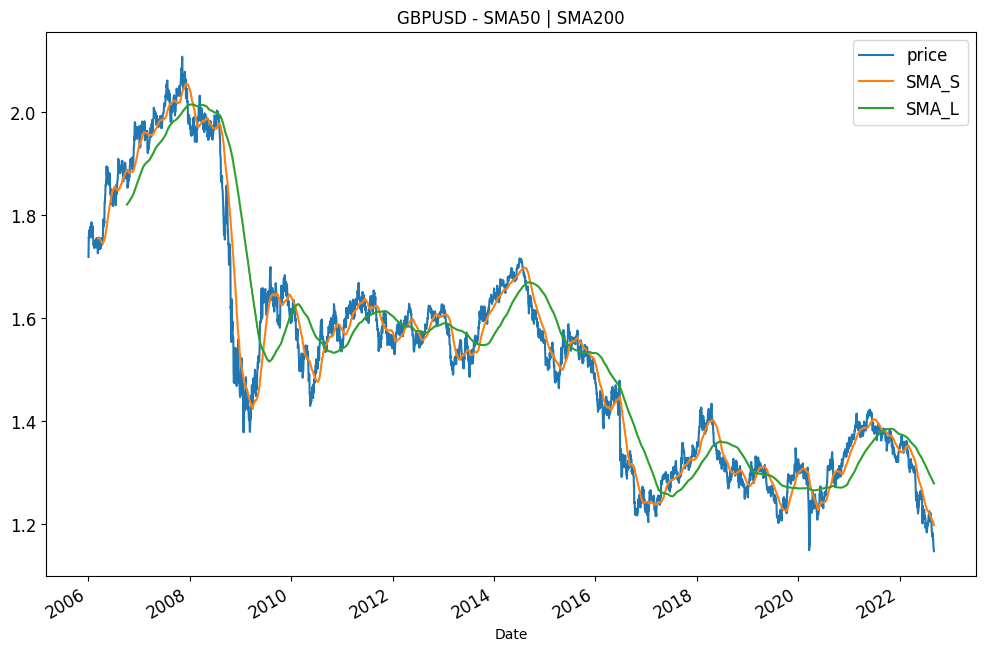

In [48]:
GBPUSD = yf.download("GBPUSD=x", start = "2006-01-01", end = "2022-09-06")
data = pd.DataFrame()
data["price"] = GBPUSD["Close"]
sma_s = 50
sma_l = 200
data["SMA_S"] = data.price.rolling(sma_s).mean()
data["SMA_L"] = data.price.rolling(sma_l).mean()
data.plot(figsize = (12, 8), title = "GBPUSD - SMA{} | SMA{}".format(sma_s, sma_l), fontsize = 12)
plt.legend(fontsize = 12)
plt.show()

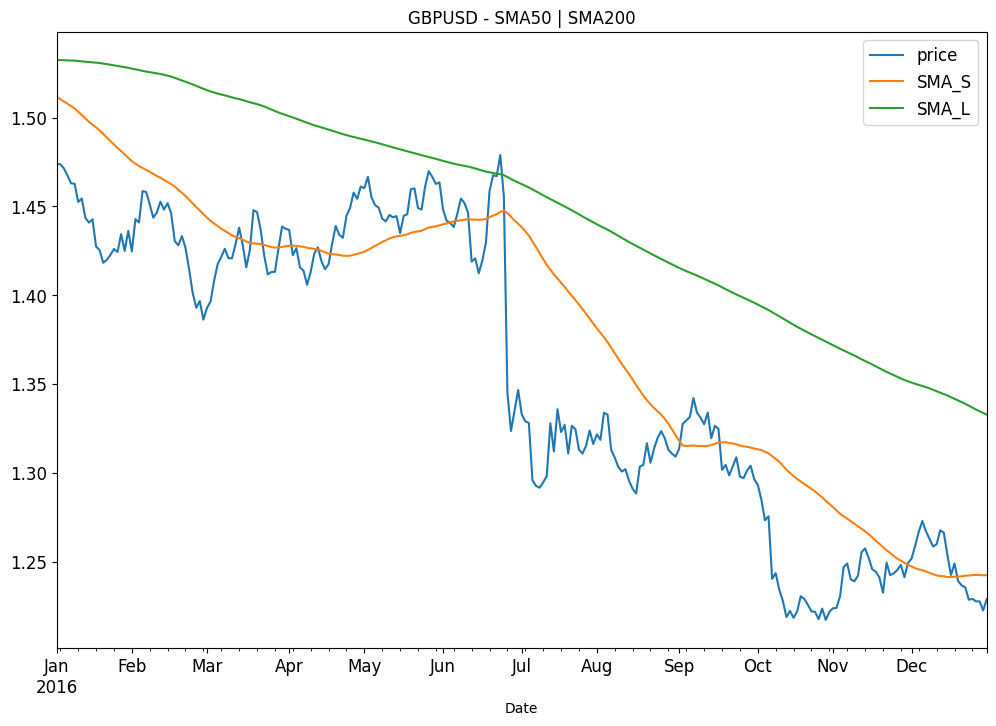

In [49]:
data.dropna(inplace = True)
# Plot 2015 GBPUSD
data.loc["2016"].plot(figsize = (12, 8), title = "GBPUSD - SMA{} | SMA{}".format(sma_s, sma_l), fontsize = 12)
plt.legend(fontsize = 12)
plt.show()

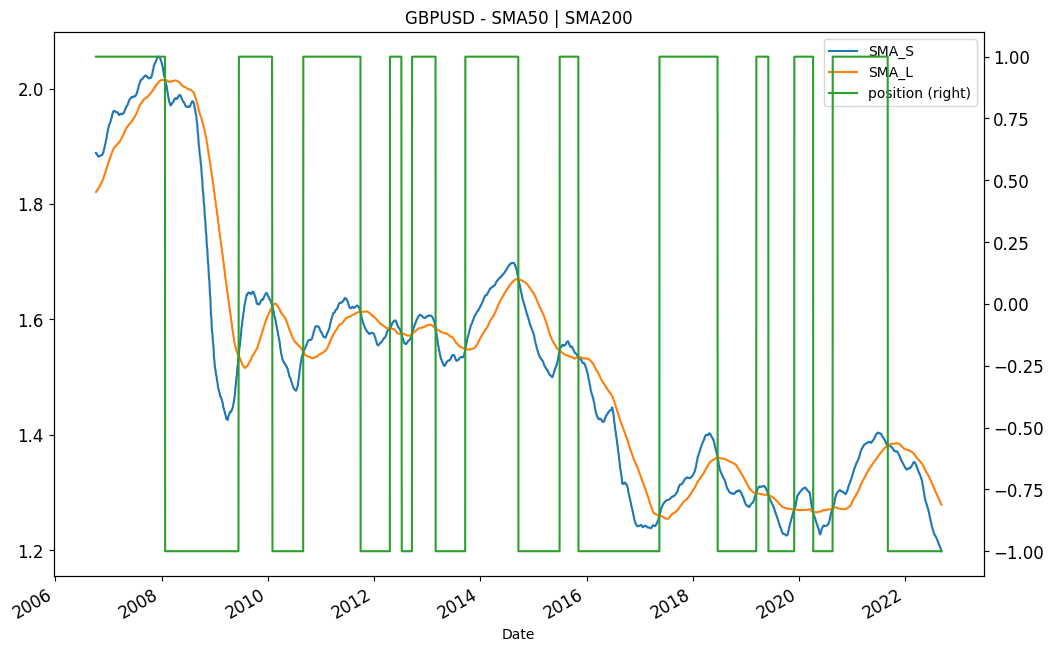

In [50]:
data["position"] = np.where(data["SMA_S"] > data["SMA_L"], 1, -1 )
data.loc[:, ["SMA_S", "SMA_L", "position"]].plot(figsize = (12, 8), fontsize = 12, secondary_y = "position",
                                                title = "GBPUSD - SMA{} | SMA{}".format(sma_s, sma_l))
plt.show()

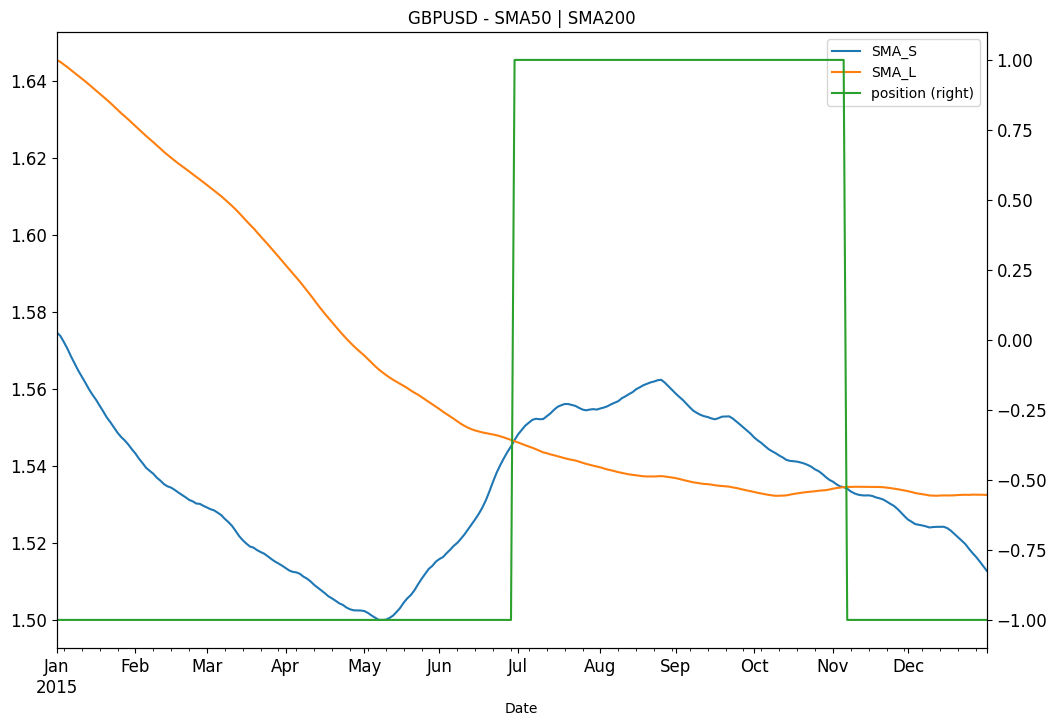

In [51]:
data.loc["2015", ["SMA_S", "SMA_L", "position"]].plot(figsize = (12, 8), fontsize = 12, secondary_y = "position",
                                                     title = "GBPUSD - SMA{} | SMA{}".format(sma_s, sma_l))
plt.show()

### Vectorized Strategy Backtesting


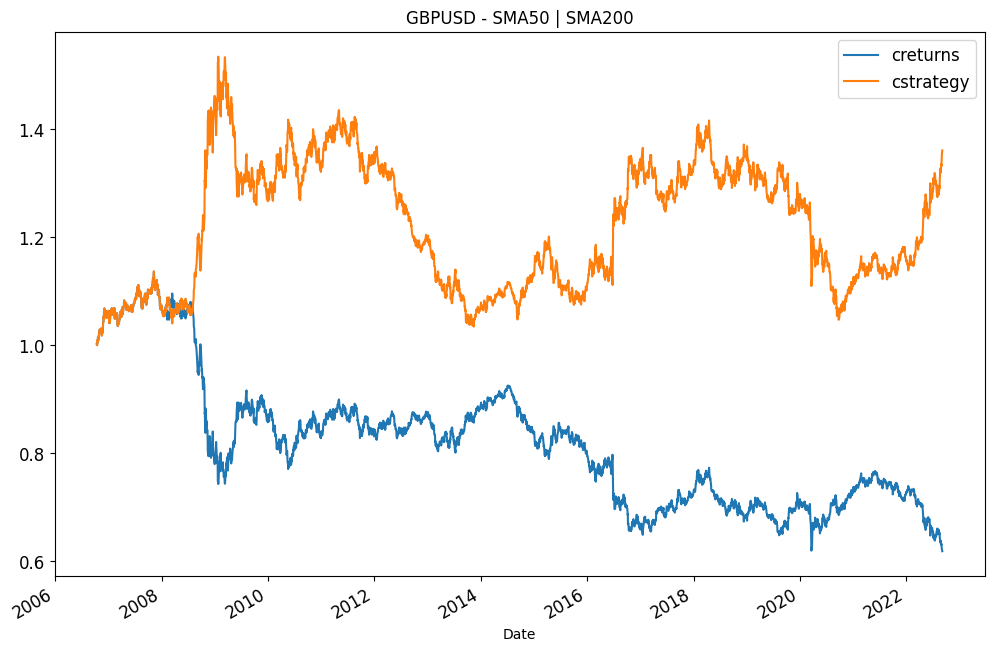

,price,SMA_S,SMA_L,position,returns,strategy,creturns,cstrategy
Date,,,,,,,,
2016-01-01,1.473839,1.511511,1.532443,-1,-0.005468,0.005468,0.794591,1.115519
2016-01-04,1.473709,1.510350,1.532369,-1,-0.000088,0.000088,0.794521,1.115618
2016-01-05,1.471410,1.509063,1.532322,-1,-0.001561,0.001561,0.793281,1.117360
2016-01-06,1.467394,1.507785,1.532244,-1,-0.002733,0.002733,0.791116,1.120418
2016-01-07,1.462994,1.506501,1.532140,-1,-0.003004,0.003004,0.788744,1.123789


In [55]:
data["returns"] = np.log(data.price.div(data.price.shift(1)))
# The strategy is that if we are in Long (we want to buy)
# The amount we want to buy should be proportinal to the relative .
data["strategy"] = data.position.shift(1) * data["returns"]
data.dropna(inplace = True)
# creturns - Cumulative returns (e^(cumulative return))
data["creturns"] = data["returns"].cumsum().apply(np.exp)
data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
data[["creturns", "cstrategy"]].plot(figsize = (12, 8), title = "GBPUSD - SMA{} | SMA{}".format(sma_s, sma_l), fontsize = 12)
plt.legend(fontsize = 12)
plt.show()
data.loc["2016"].head()

In [39]:
outperf = data.cstrategy.iloc[-1] - data.creturns.iloc[-1]
outperf

0.7372895087151791

### Finding the Optimal SMA Strategy

In [46]:
GBPUSD = yf.download("GBPUSD=x", start = "2006-01-01", end = "2022-09-06")
data = pd.DataFrame()
data["price"] = GBPUSD["Close"]
data.head()

[*********************100%***********************]  1 of 1 completed


,price
Date,
2006-01-02,1.719188
2006-01-03,1.748588
2006-01-04,1.757315
2006-01-05,1.755310
2006-01-06,1.770789


In [41]:
def test_strategy(SMA):
    """ Gives the profit of the strategy of the SMA  ranges
    
    Input:
    - SMA : tuple (SMA_S,SMA_L) 
    """
    data["returns"] = np.log(data.price.div(data.price.shift(1)))
    data["SMA_S"] = data.price.rolling(int(SMA[0])).mean()
    data["SMA_L"] = data.price.rolling(int(SMA[1])).mean()
    data.dropna(inplace = True)
    
    data["position"] = np.where(data["SMA_S"] > data["SMA_L"], 1, -1)
    data["strategy"] = data.position.shift(1) * data["returns"]
    data.dropna(inplace = True)
    
    
    return np.exp(data["strategy"].sum())

In [43]:
SMA_S_range = range(10, 50, 1)
SMA_L_range = range(100, 252, 1)
from itertools import product
combinations = list(product(SMA_S_range, SMA_L_range))
results = []
for comb in combinations:
    results.append(test_strategy(comb))
# Best strategy
combinations[np.argmax(results)]

many_results = pd.DataFrame(data = combinations, columns = ["SMA_S", "SMA_L"])
many_results["performance"] = results

# Top 10 performers: many_results.nlargest(10, "performance")
# Btm 10 performers: many_results.nsmallest(10, "performance")